In [40]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
jit_level = tf.compat.v1.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level

In [41]:
import keras
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [42]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [43]:
import python_speech_features
import numpy as np
import soundfile as sf
import pickle
import cv2
import glob

In [44]:
window_length = 19

In [45]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [46]:
#from keras.models import Sequential
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# define model
n_in = 19
with tf.device("/GPU:0"):
#from keras.models import Sequential
    model = Sequential()
    model.add(LSTM(256, activation='tanh', return_sequences=True,input_shape=(19,39)))
    model.add(Dropout(0.2))
    model.add(LSTM(512, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(RepeatVector(n_in))
    model.add(LSTM(512, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(39)))

    model.summary()

    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 19, 256)           303104    
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 19, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 19, 512)           2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 512)          

In [47]:
from keras.models import load_model
model.load_weights('/home/orchids/Documents/BTP_Vaishnavi_Joshitha/Weights/wts_512.h5')

In [48]:
feat_file = open("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Train/telugu_feature_vect.pkl", "rb")
sequence = pickle.load(feat_file)

In [49]:
out = model.layers[2].output
m = tf.compat.v1.keras.Model(inputs = model.input, outputs=out)

In [50]:
output = m.predict(sequence)

In [51]:
print(len(output[0]))
print(len(output))

512
195868


In [53]:
features = output
n_gmms=512
from sklearn.mixture import GaussianMixture
gmm_512_512 = GaussianMixture(n_components=n_gmms)

In [54]:
with tf.device("/GPU:0"):
    gmm_512_512.fit(features)
    score = gmm_512_512.score_samples(features)

In [55]:
pickle.dump(gmm_512_512, open('gmm_512_512.sav', 'wb'))

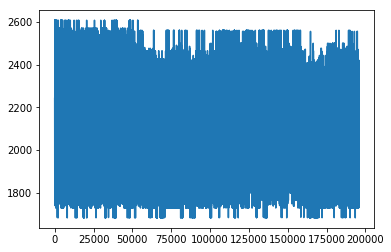

In [15]:
plt.plot(score)

In [16]:
gmm_512_1024.lower_bound_

2117.793048732473

In [17]:
pickle.dump(gmm_512_1024, open('gmm_512_1024.sav', 'wb'))

In [18]:
import csv
import pandas as pd
list = ['File Name','Sequence']
train_df = pd.read_csv("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Train/Transcription_LT_Sequence_Frame_Level_200_actual.tsv", delimiter="\t",names=list)
train_df['File Name'] = train_df['File Name'].apply(lambda x: str(x))
for x in range(0,len(train_df['File Name'])):
    train_df['File Name'][x] = str(str(train_df['File Name'][x]).zfill(9))
train_df

,File Name,Sequence
0,000010010,SSTTTTTTTTTTEEEEEETTSEEEEESSSSTTTTTTSSSSSSSSTT...
1,000010012,SSEEEETTSTTTTTTTTTTTTTTTTTTTTTSS
2,000010017,SSEEETTTTTTTTTTTTTTTTTTTTTTS
3,000010023,SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS
4,000010030,SSTTTTTTTTTTEETTTS
5,000010035,SSTTTTTTTTTTTTTTSEETTTS
6,000010051,SSSTSTTTTTTTETTTTTTSSTTTTTTTTSS
7,000010107,SSTTTTTTTTTTETTTTTSTTTTTTTTS
8,000010110,SSTEETTTTTTTTTEEESTTEETTTEETTTTS
9,000010138,SSTTTTTTTTTTTTSEEETTSTTTTTTTTTS


SSTTTTTTTTTTTTTTTTTTEESSSSSSEEEEEEETTTTTTTTSS


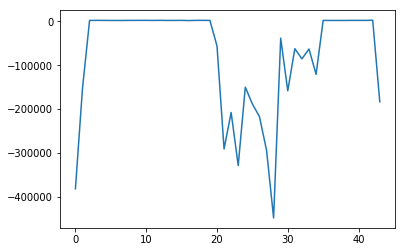

gmm_512_1024
S :  -381424.50203697087
S :  -152661.86871433305
T :  2026.2601895747935
T :  2233.1888625572296
T :  2153.6693617815536
T :  2019.661586607483
T :  1939.169468286253
T :  2063.998426469688
T :  2150.5006601864443
T :  2193.242116430102
T :  2253.6043658764584
T :  2103.9199208294835
T :  2253.606930140012
T :  2043.0573136719142
T :  2053.9691329001585
T :  2201.3427664874744
T :  1793.4292212026387
T :  2175.4960315880553
T :  2245.003259961778
T :  2120.7352184939064
E :  -55860.323135817496
E :  -290708.2372160437
S :  -207711.2843450815
S :  -328347.39616914996
S :  -149889.28635509821
S :  -188267.9904972934
S :  -216953.0503044998
S :  -293458.63115559414
E :  -447818.44458515465
E :  -38353.5558918591
E :  -158275.65547000265
E :  -62313.56095295072
E :  -85416.30207617857
E :  -63072.867913826456
E :  -120743.9742610908
T :  2128.569286637303
T :  1991.3254880220643
T :  2033.239243919389
T :  1995.4233879305566
T :  2175.507561163533
T :  2161.433525374091
T :  

In [24]:
from keras.models import load_model
#model.load_weights('Weights/wts_512.h5')

file_name = '000010023'
file_path ="PartB_Telugu/Train/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = train_df.loc[train_df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[2].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_512_1024 = gmm_512_1024.score_samples(output256)

plt.plot(score_512_1024)
plt.show()
print('gmm_512_1024')
for i in range(0,len(score_512_1024)):
  print(seq[i],": ",score_512_1024[i])

Testing

In [26]:
import csv
import pandas as pd
list = ['File Name','Sequence']
test_df = pd.read_csv("/home/orchids/Documents/BTP_Vaishnavi_Joshitha/PartB_Telugu/Dev/Transcription_LT_Sequence_Frame_Level_200_actual.tsv", delimiter="\t",names=list)
test_df['File Name'] = test_df['File Name'].apply(lambda x: str(x))
for x in range(0,len(test_df['File Name'])):
    test_df['File Name'][x] = str(str(test_df['File Name'][x]).zfill(9))
#test_df

SSEEEEETTTTTTTETTTSS


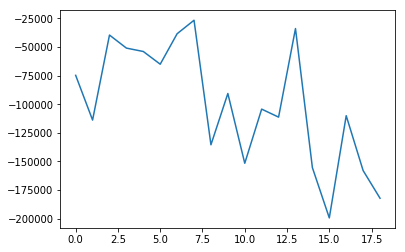

gmm_512_1024
S :  -74840.37619391251
S :  -113878.0451784528
E :  -39679.55347108169
E :  -51062.99518941768
E :  -54031.43925300196
E :  -65118.11123262397
E :  -38532.97948746165
T :  -26757.001068856556
T :  -135451.15635175697
T :  -90692.17926475916
T :  -151579.0284060776
T :  -104323.72198728795
T :  -111309.83402923854
T :  -34017.18039925274
E :  -155395.1872305683
T :  -199276.77169629367
T :  -110071.66914927766
T :  -157940.92893062843
S :  -182115.54875261628


In [28]:
from keras.models import load_model
#model.load_weights('wts_256_tanh.h5')

file_name = '000010234'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = test_df.loc[test_df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[2].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_512_1024 = gmm_512_1024.score_samples(output256)

plt.plot(score_512_1024)
plt.show()
print('gmm_512_1024')
for i in range(0,len(score_512_1024)):
  print(seq[i],": ",score_512_1024[i])

512_2048

In [31]:
features = output
n_gmms=2048
from sklearn.mixture import GaussianMixture
gmm_512_2048 = GaussianMixture(n_components=n_gmms)

In [32]:
with tf.device("/GPU:0"):
    gmm_512_2048.fit(output)

In [58]:
pickle.dump(gmm_512_2048, open('gmm_512_2048.sav', 'wb'), protocol=4)

In [57]:
score = gmm_512_2048.score_samples(output)
plt.plot(score)

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
#model.load_weights('wts_256_tanh.h5')

file_name = '000010023'
file_path ="PartB_Telugu/Train/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_2048')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

SSEEEEETTTTTTTETTTSS


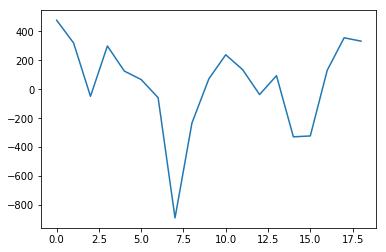

gmm_256_1024
S :  477.11966254918616
S :  320.0541506155049
E :  -48.78999155128258
E :  299.0455449400629
E :  125.64015904983148
E :  66.68700093507745
E :  -58.46947938859499
T :  -889.8418258773517
T :  -233.64700537193005
T :  71.98866334768685
T :  238.35376162598027
T :  135.08288587340357
T :  -36.80881742810458
T :  93.83605167883856
E :  -329.15374894147806
T :  -323.04112127228035
T :  130.89247585999777
T :  355.854189915808
S :  332.58677680184303


In [83]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010234'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_1024')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

SSSSSSSSSTTTEEETTSETTTTTTTTTTTTTTTTSS


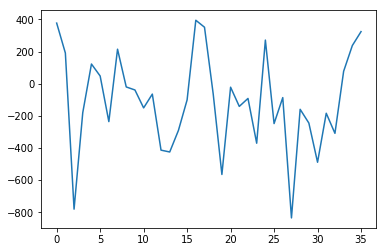

gmm_256_2048
S :  377.48535102518645
S :  191.14920490756333
S :  -780.8175061730711
S :  -180.40416483954965
S :  122.73787550921784
S :  48.13658594013982
S :  -235.83015295582408
S :  214.8813460815319
S :  -20.019895155062258
T :  -38.8990843373977
T :  -150.4300577561819
T :  -64.60418060889992
E :  -413.4487457148333
E :  -424.911619517157
E :  -290.86546348454783
T :  -100.53031318589655
T :  395.1985505313583
S :  351.7029775339279
E :  -63.37195877487635
T :  -564.9194310002168
T :  -21.586109326399587
T :  -141.16699339294598
T :  -91.51464587312353
T :  -370.3614805742376
T :  271.6963626046934
T :  -248.0403498218506
T :  -86.34640007205267
T :  -835.3600941657404
T :  -159.35275783951727
T :  -244.79825194001637
T :  -488.8898195233504
T :  -183.82930823210415
T :  -308.76181679766285
T :  77.59231873073499
T :  237.73710428497282
S :  324.3966960227248


In [85]:
from keras.models import load_model
model.load_weights('wts_256_tanh.h5')

file_name = '000010443'
file_path ="PartB_Telugu/Dev/Audio/"+file_name+'.wav'
data, fs = sf.read(file_path)
seq = df.loc[df['File Name'] == file_name, 'Sequence'].iloc[0]

fin = []  #200 ms frames in the file_name
frame = int(0.2*fs)

for i in range(0,len(seq)):
    if len(data[frame*i:frame*i+frame])==3200:
      fin.append((data[frame*i:frame*i+frame]).tolist())

final_feat_vec = []
for data in fin:
  data = np.array((data))
  feat_file = []
  mfcc_feat = python_speech_features.mfcc(data,16000,winlen=0.02,winstep=0.01)
  #-------Compute delta coef-----#
  N=2
  delta = python_speech_features.delta(mfcc_feat, 2)
  #--------Compute delta-delta coeff-------#
  delta_delta = python_speech_features.delta(delta, 2)

  for frame in range(0,len(mfcc_feat)):
    #frame opened
    #concatenate for each frame : 13 mfcc + 13 delta + 13 delta-delta = 39 features
    feat_ = np.concatenate((mfcc_feat[frame],delta[frame],delta_delta[frame]))
    feat_file.append(feat_)

  final_feat_vec.append(feat_file)

for i in range(0,len(final_feat_vec)):
  final_feat_vec[i] = np.stack( final_feat_vec[i], axis=0 )

t = np.array(final_feat_vec)
print(seq)

#------Method 1--------#
model_256 = model
out_256 = model_256.layers[1].output
m_256 = tf.compat.v1.keras.Model(inputs = model_256.input, outputs=out_256)

output256 = m_256.predict(t)

score_256_2048 = gmm_256_2048.score_samples(output256)

plt.plot(score_256_2048)
plt.show()
print('gmm_256_2048')
for i in range(0,len(score_256_2048)):
  print(seq[i],": ",score_256_2048[i])

4096

In [88]:
gmm_256_4096 = GaussianMixture(n_components=4096)

with tf.device("/GPU:0"):
    gmm_256_4096.fit(output)
    
pickle.dump(gmm_256_4096, open('gmm_256_4096.sav', 'wb'))

score = gmm_256_4096.score_samples(output)
plt.plot(score)

MemoryError: 

In [16]:
tf.config.list_physical_devices('XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]